### Highpass Synapse Model

In [925]:
import sys
print (sys.executable)
#print (sys.path)

import nengo
import nengo.spa as spa
from nengo.networks import Integrator
from nengo.utils.compat import is_number
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ensemble import response_curves
from nengo.dists import Choice
from nengo.dists import Uniform
from nengo.dists import Gaussian
from nengo.utils.functions import piecewise
from nengo.utils.matplotlib import rasterplot

import nengo_gui
from nengo_gui.ipython import IPythonViz

#import seaborn as sns
#sns.set_style('whitegrid')
#sns.set_context("paper")

import numpy as np
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['legend.fontsize'] = 15

In [342]:
def highpass(tau, order=1):
    """Differentiated lowpass, raised to a given power."""
    if order < 1 or not is_number(order):
        raise ValueError("order (%s) must be integer >= 1" % order)
    num, den = map(np.poly1d, ([tau, 0], [tau, 1]))
    return nengo.LinearFilter(num**order, den**order)

### MMN
Using variation in intensity of the stimulus as an oddball.

In [864]:
# Setup the experiment

dev_trials = []
std_trials = []

isi = 500.0/1000.0          # inter-stimulus interval
stim_dur = 200.0/1000.0       # stimulus duration
trial_len = isi + stim_dur  # length of each trial

prestimulus_baseline = 0  # 100 ms  -  this can also be set to 0
remove_beg = int((trial_len - prestimulus_baseline) * 1000)  # remove this much ms of stimulus from the beginning

class Experiment(object):
    def __init__(self, seed=None, isi=isi, stim_dur=stim_dur, std_value=4, dev_value=8, trial_len=trial_len, 
                                                                            prestim_baseline=prestimulus_baseline):
        self.rng = np.random.RandomState(seed=seed)
        self.prestim_baseline = prestim_baseline
        self.isi = isi
        self.stim_dur = stim_dur
        self.trial_len = trial_len
        self.std_value = std_value
        self.dev_value = dev_value
        self.prev_rise = 0
        self.stim_value = 0
        self.trial_number = 0   
        self.inhib = 0
        self.reset_evidence = 'NONE'
    
    # provide stimulus for each trial and keep
    # track of deviant and standard trials
    def stimulus_in(self, t):         
        # pull up the value to 0.4 or 0.8
        if int(t*1000) % int(self.trial_len*1000) == 0:
            self.reset_evidence = 'NONE'
            self.trial_number = self.trial_number+1 # increment the trial counter
            self.prev_rise = t
            self.inhib = 0
            self.stim_value = np.random.choice((self.std_value, self.dev_value), p=(0.8, 0.2))                          
            if self.stim_value == self.dev_value:
                dev_trials.append(self.trial_number)    # store the trial numbers of oddballs
            elif self.stim_value == self.std_value:
                std_trials.append(self.trial_number)
        # pull down the value - bring it back to 0
        elif int(t*1000) == (int (self.prev_rise*1000) + self.stim_dur*1000):
            #self.reset_evidence = 'RESET'
            self.stim_value = 0
        return self.stim_value
    
    
    def inhibit_in(self, t):
        if int(t*1000) % (int(self.trial_len*1000)-int(self.prestim_baseline*1000)) == 0: 
                                                # and t!=0: (not needed - 1st trial removed anyways, better without)
            self.inhib = 1
        return self.inhib
    
    
    def reset_in(self, t):
        return self.reset_evidence
        
    

In [999]:
dev_trials = []
std_trials = []

# Build nengo model
tau_highpass = 0.5
seed=6
D = 16

# we'll use this to reset the accumulated evidence to zero
#reset_vocab = spa.Vocabulary(D)
#reset_vocab.parse('RESET')

model = nengo.Network(seed=seed)
# run in direct mode to verify
model.config[nengo.Ensemble].neuron_type=nengo.LIF() #nengo.Direct() # #nengo.LIFRate() 
model.config[nengo.Ensemble].max_rates=Uniform(20,120)
model.config[nengo.Ensemble].radius=10
with model:
    
    exp = Experiment(seed=seed)
    stim = nengo.Node(exp.stimulus_in)
    stim_inhib = nengo.Node(exp.inhibit_in)
  
    # create the ensemble with added noise at the input of each neuron
    result = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise(Gaussian(0,1)))
    nengo.Connection(stim, result, synapse=highpass(tau_highpass), transform=1.5)
    #nengo.Connection(stim_inhib, result.neurons, transform=[[-2.5]]*result.n_neurons) # inhibit result during 
                                                                                        # prestimulus period
    '''   
    result2 = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise())    
    nengo.Connection(stim, result2, synapse=highpass(tau_highpass, order=4))
    result2_p = nengo.Probe(result2, synapse=0.05)
    '''
    
    result_2ser = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise())    
    nengo.Connection(result, result_2ser, synapse=highpass(tau_highpass))
    result_2ser_p = nengo.Probe(result_2ser, synapse=0.03)
    
    
    result_3ser = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise())    
    nengo.Connection(result_2ser, result_3ser, synapse=highpass(tau_highpass))
    result_3ser_p = nengo.Probe(result_3ser, synapse=0.03)
    
    
    result_4ser = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise())#, encoders=np.ones((200, 1)))    
    nengo.Connection(result_3ser, result_4ser, synapse=highpass(tau_highpass))
    result_4ser_p = nengo.Probe(result_4ser, synapse=0.03)
    
    result_5ser = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise())    
    #nengo.Connection(result_4ser, result_5ser, synapse=highpass(tau_highpass))
    result_5ser_p = nengo.Probe(result_5ser, synapse=0.03)
    
    # feedback
    nengo.Connection(result_4ser, result)
          
    # evidence memory - should be reset at the end of every trial
    evidence_scale = 1  # controls how quickly the evidence is accumulated
    evidence = nengo.Ensemble(n_neurons=200, dimensions=2) #, noise=nengo.processes.BrownNoise(Gaussian(0,1)))
                             #encoders=np.ones((500, 2)))  # SS-noise seems  
                                                             # to be useful in getting a relatively stable pattern
    
    
    def response(x):
        sensory, accum = x
        accum = (0.85*sensory+0.15*accum)*1.4
        return 0, accum
    
    nengo.Connection(evidence, evidence, synapse=0.1, function=response)
    nengo.Connection(result, evidence[0], transform=1) # SS-seems like higher the transform, the better
                                                # 0.6 seems optimal - 4s are always less than 5 and 8s always reaching 7
    
    
    result_copy = nengo.Ensemble(200, dimensions=1, noise=nengo.processes.BrownNoise())
    nengo.Connection(result, result_copy, synapse=0.03)
    nengo.Connection(evidence[1], result_copy, synapse=0.03)   
    result_copy_p = nengo.Probe(result_copy, synapse=0.03)
   
    '''
    # this stores the accumulated evidence 
    model.evidence = spa.State(1, feedback=1, feedback_synapse=0.1, encoders=[[1]])
    
    # we also need a method for resetting the evidence population.  
    # If this associative memory is set to RESET then it should 
    # reset the model.evidence population to zero   
    # reset is biologically implausible so I am not using it for now
    model.reset = spa.AssociativeMemory(reset_vocab)
    nengo.Connection(model.reset.am.elem_output[0], model.evidence.all_ensembles[0].neurons, 
                     transform=np.ones((model.evidence.all_ensembles[0].n_neurons, 1))*-10, 
                     synapse=0.1)
    # this scaling factor controls how quickly the evidence is accumulated 
    evidence_scale = 0.3
    nengo.Connection(result, model.evidence.input, transform=0.2)
    model.input = spa.Input(reset=exp.reset_in)
    '''
    
    stim_p = nengo.Probe(stim, synapse=None)
    result_p = nengo.Probe(result, synapse=0.03)
    evidence0_p = nengo.Probe(evidence[0], synapse=0.03)
    evidence1_p = nengo.Probe(evidence[1], synapse=0.03)
    #evidence_p = nengo.Probe(model.evidence.output, synapse=0.05)
    #reset_p = nengo.Probe(model.reset.output, synapse=0.05)
    
sim = nengo.Simulator(model)
sim.run(40)   # run for 10 minutes 

c:\users\susharma\desktop\git\nengo\nengo\builder\optimizer.py:636: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn("Skipping some optimization steps because SciPy is "


In [938]:
IPythonViz(model, "threshold.py.cfg")

c:\users\susharma\desktop\git\nengo\nengo\builder\optimizer.py:636: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn("Skipping some optimization steps because SciPy is "


(23, 32)

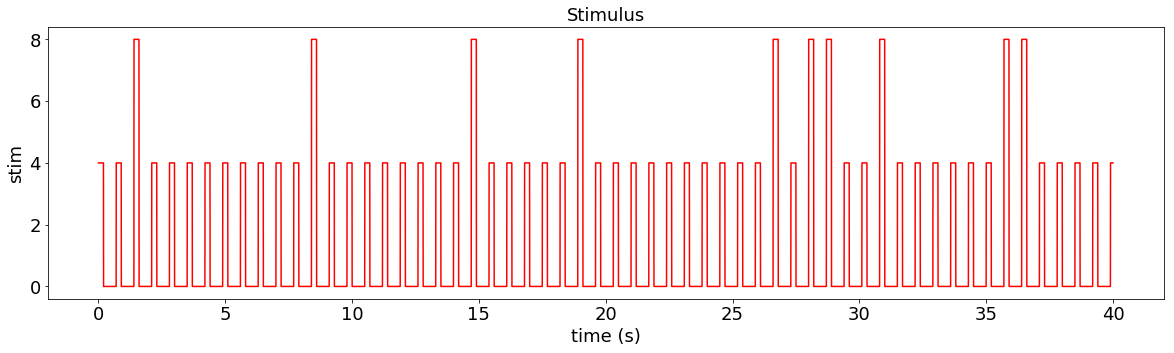

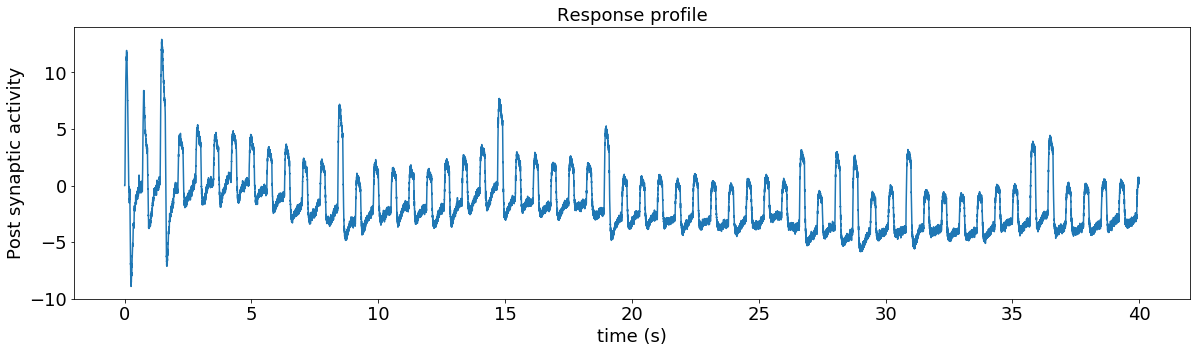

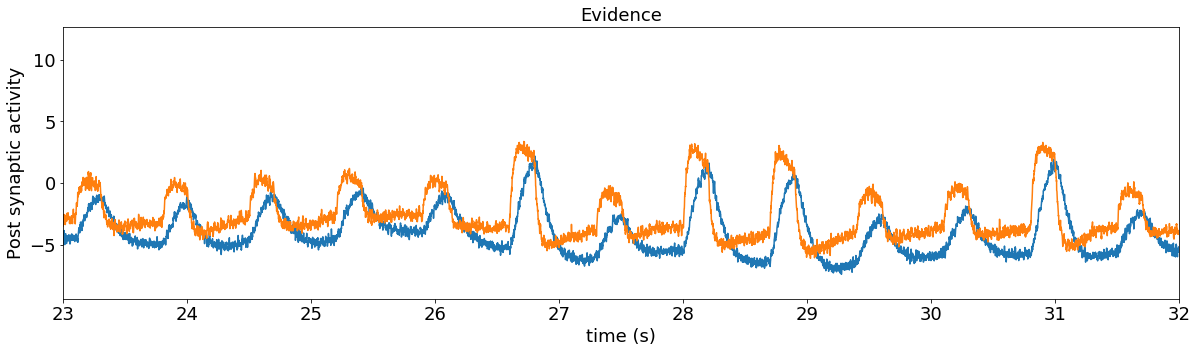

In [1000]:
# plot the stimulus and response
t = sim.trange()

plt.figure(figsize=(20,5))
plt.plot(t, sim.data[stim_p], 'r')
plt.ylabel("stim")
plt.xlabel("time (s)")
plt.title("Stimulus")
#plt.xlim(13, 18)

plt.figure(figsize=(20,5))
plt.plot(t, sim.data[result_p])
plt.ylabel("Post synaptic activity")
plt.xlabel("time (s)")
plt.title("Response profile")     
#plt.xlim(13, 18)

plt.figure(figsize=(20,5))
plt.plot(t, sim.data[evidence1_p])
plt.plot(t, sim.data[evidence0_p])
plt.ylabel("Post synaptic activity")
plt.xlabel("time (s)")
plt.title("Evidence")     
plt.xlim(23, 32)

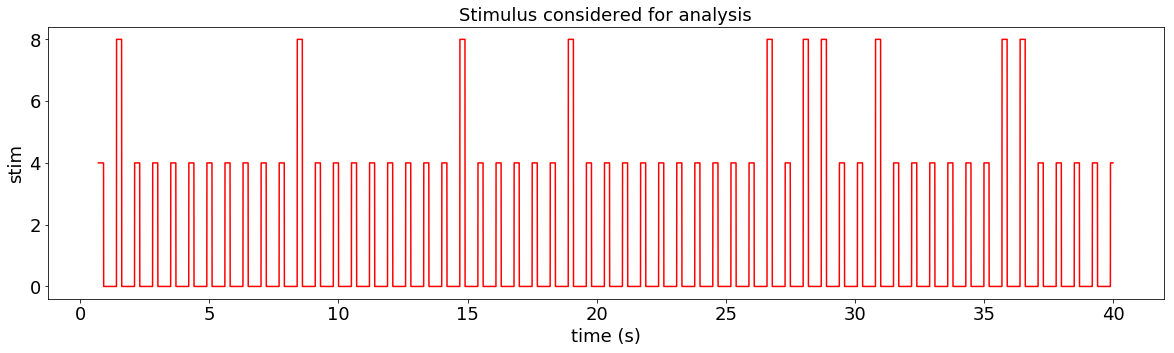

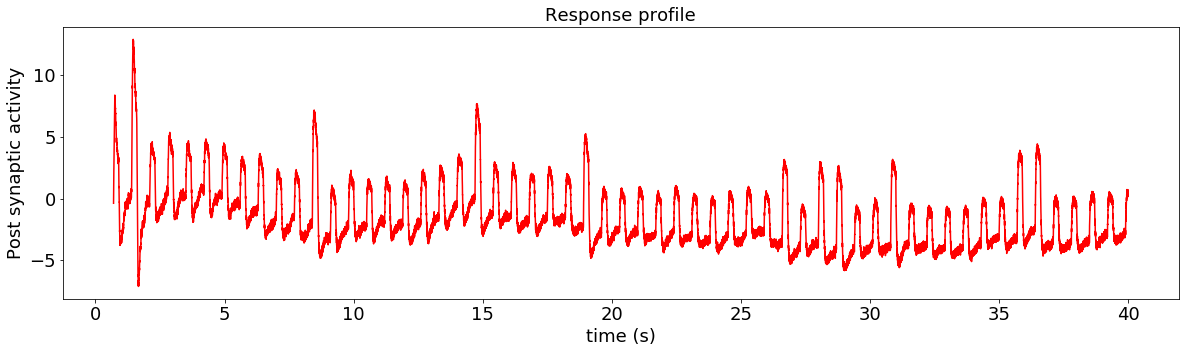

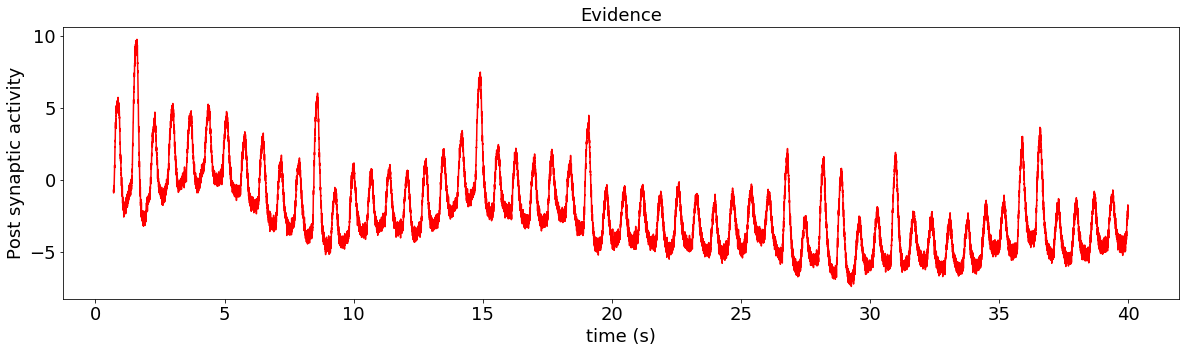

In [1001]:
# stimulus and response profile after removing the first stimulus
# and adding the pre-stimulus baseline
test = sim.data[stim_p]
test = test[remove_beg:] 
plt.figure(figsize=(20,5))
plt.plot(t[remove_beg:], test, 'r')
plt.ylabel("stim")
plt.xlabel("time (s)")
plt.title("Stimulus considered for analysis")
#plt.xlim(0, 3)

test = sim.data[result_p]
test = test[remove_beg:] 
plt.figure(figsize=(20,5))
plt.plot(t[remove_beg:], test, 'r')
plt.ylabel("Post synaptic activity")
plt.xlabel("time (s)")
plt.title("Response profile") 
#plt.xlim(0, 3)

test = sim.data[evidence1_p]
test = test[remove_beg:] 
plt.figure(figsize=(20,5))
plt.plot(t[remove_beg:], test, 'r')
plt.ylabel("Post synaptic activity")
plt.xlabel("time (s)")
plt.title("Evidence") 
#plt.xlim(0, 3)

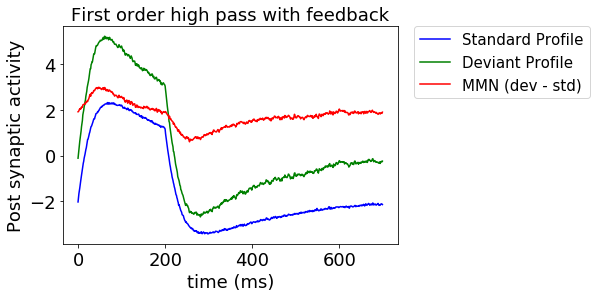

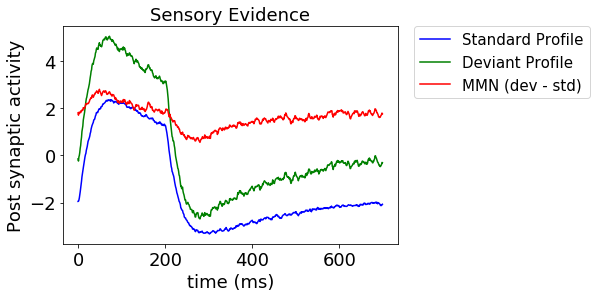

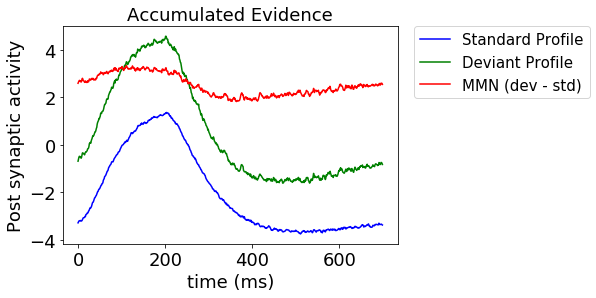

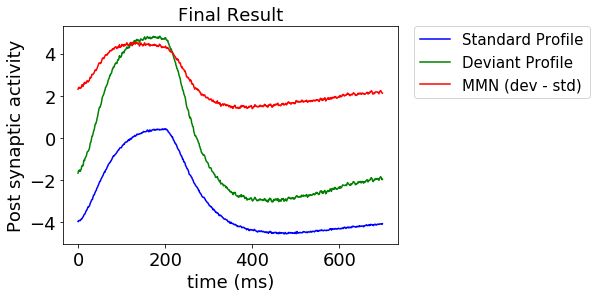

In [1002]:
# Post Processing to get mmn

def analyse(probe, title):
    data = sim.data[probe]
    data = data[remove_beg:]   # remove the first trial

    num_trials = int(np.floor(len(data) / float(trial_len*1000)))
    trial_data = data[:num_trials*int(trial_len*1000)]
    #print "Number of deviant trials: ", len(dev_trials)
    #print "Number of standard trials: ", len(std_trials)
    #print dev_trials
    #print std_trials

    # remove the first and the last (unfinished trial)
    for x in dev_trials:
        if x>num_trials or x == 1:
            dev_trials.remove(x)

    for y in std_trials:        
        if y>num_trials or x == 1:
            std_trials.remove(y)

    #print "Number of trials: ", num_trials
    #print "Number of deviant trials: ", len(dev_trials)
    #print "Number of standard trials: ", len(std_trials)

    trial_data = trial_data.reshape(num_trials, int(trial_len*1000))
    dev_data = trial_data[np.where(dev_trials)]
    std_data = trial_data[np.where(std_trials)]

    #print len(dev_data)
    #print len(std_data)

    avg_dev_data = np.average(dev_data, axis=0)
    avg_std_data = np.average(std_data, axis=0)

    mmn = avg_dev_data-avg_std_data

    plt.figure()
    plt.title(title)
    plt.plot(range(int(trial_len*1000)), avg_std_data, 'b')
    plt.plot(range(int(trial_len*1000)), avg_dev_data, 'g')
    plt.plot(range(int(trial_len*1000)), mmn, 'r')
    plt.ylabel("Post synaptic activity")
    plt.xlabel("time (ms)")
    plt.legend(["Standard Profile","Deviant Profile","MMN (dev - std)"] , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    
analyse(result_p, "First order high pass with feedback") 
#analyse(result2_p, "Fourth order high pass")
#analyse(result_2ser_p, "Two consecutive first order high pass")
#analyse(result_3ser_p, "Three consecutive first order high pass")
#analyse(result_4ser_p, "Four consecutive first order high pass")
#analyse(result_5ser_p, "Five consecutive first order high pass")
analyse(evidence0_p, "Sensory Evidence")
analyse(evidence1_p, "Accumulated Evidence")
analyse(result_copy_p, "Final Result")

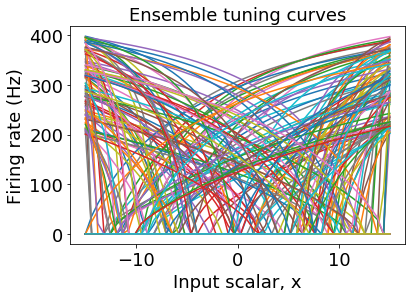

In [124]:
# plot ensemble tuning curves
with sim:
    plt.figure()
    plt.plot(*tuning_curves(result, sim))
    plt.ylabel("Firing rate (Hz)")
    plt.xlabel("Input scalar, x")
    plt.title("Ensemble tuning curves")